In [2]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd

from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from balu3.fs.sel import clean
from copy import deepcopy
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Tratamiento de datos

In [3]:
# Verificar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Cargar datos desde archivos .npy
X = np.load("InGameDataOrdenada\Space4x3Time5.npy")
y = np.load("InGameDataOrdenada\LabelsSpace4x3Time5.npy")

# Convertir los datos a tensores de PyTorch
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Preprocesamiento: Normalización de los datos
scaler = MinMaxScaler()
n_samples, sequence_length, n_features = X.shape
X_flat = X.view(-1, n_features)
X_flat = torch.tensor(scaler.fit_transform(X_flat), dtype=torch.float32)
X = X_flat.view(n_samples, sequence_length, n_features)

# División de los datos en 65% entrenamiento, 15% validación y 20% prueba
train_size = int(0.65 * n_samples)
val_size = int(0.15 * n_samples)
test_size = n_samples - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Mover los datos a la GPU si está disponible
X_train, X_val, X_test = X_train.to(device), X_val.to(device), X_test.to(device)
y_train, y_val, y_test = y_train.to(device), y_val.to(device), y_test.to(device)


Using device: cuda


# Modelos Transformer

In [8]:
class TransformerLSTMClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=2, hidden_dim=128, lstm_hidden_dim=64, dropout=0.1, sequence_length=18):
        super(TransformerLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(lstm_hidden_dim * 2, hidden_dim)
        self.pos_encoder = nn.Parameter(torch.zeros(1, sequence_length, hidden_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_key_padding_mask=None):
        x, _ = self.lstm(x)
        x = self.embedding(x)
        x = x + self.pos_encoder[:, :x.size(1), :]
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        x = self.dropout(x.mean(dim=1))  # Global average pooling con dropout
        x = self.fc_out(x)
        return x
    
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=2, hidden_dim=128, dropout=0.1, sequence_length=18):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = nn.Parameter(torch.zeros(1, sequence_length, hidden_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_encoder[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc_out(x)
        return x

In [9]:
input_dim = n_features
num_classes = len(torch.unique(y))
num_heads = 8
num_layers = 4
hidden_dim = 256
dropout = 0.1
lstm_hidden_dim = 128
sequence_length = 18

In [10]:

modelo_cargado = torch.load("models\ModeloSimple.pth")

ModeloSimpleL2 = TransformerClassifier(input_dim, num_classes, num_heads, num_layers, hidden_dim, dropout, sequence_length).to(device)
ModeloSimpleL2.load_state_dict(modelo_cargado["model_state_dict"])

modelo_cargado = torch.load("models\ModeloPaddingL2.pth")

ModeloPaddingL2 = TransformerClassifier(input_dim, num_classes, num_heads, num_layers, hidden_dim, dropout, sequence_length).to(device)
ModeloPaddingL2.load_state_dict(modelo_cargado["model_state_dict"])

modelo_cargado = torch.load("models\ModeloLTSML2.pth")

ModeloLSTML2 =  TransformerLSTMClassifier(input_dim, num_classes, num_heads, num_layers, hidden_dim, lstm_hidden_dim, dropout, sequence_length).to(device)
ModeloLSTML2.load_state_dict(modelo_cargado["model_state_dict"])

modelo_cargado = torch.load("models\ModeloPaddingLTSML2.pth")

ModeloPaddingLSTML2 = TransformerLSTMClassifier(input_dim, num_classes, num_heads, num_layers, hidden_dim, lstm_hidden_dim, dropout, sequence_length).to(device)
ModeloPaddingLSTML2.load_state_dict(modelo_cargado["model_state_dict"])

modelos = [ModeloSimpleL2, ModeloPaddingL2, ModeloLSTML2, ModeloPaddingLSTML2]

In [11]:
general_accuracies = []
for modelo in modelos:
    accuracies = []
    modelo.eval()
    with torch.no_grad():
        for seq_len in range(1, sequence_length + 1):
            test_outputs = modelo(X_test[:, :seq_len, :])
            _, predicted = torch.max(test_outputs, 1)
            accuracy = (predicted == y_test).sum().item() / len(y_test)
            accuracies.append(accuracy)
            print(f'Sequence Length: {seq_len}, Accuracy: {accuracy * 100:.2f}%')
    general_accuracies.append(accuracies)

Sequence Length: 1, Accuracy: 30.63%
Sequence Length: 2, Accuracy: 34.64%
Sequence Length: 3, Accuracy: 38.74%
Sequence Length: 4, Accuracy: 43.24%
Sequence Length: 5, Accuracy: 47.13%
Sequence Length: 6, Accuracy: 50.24%
Sequence Length: 7, Accuracy: 53.41%
Sequence Length: 8, Accuracy: 56.25%
Sequence Length: 9, Accuracy: 59.42%
Sequence Length: 10, Accuracy: 62.73%
Sequence Length: 11, Accuracy: 66.08%
Sequence Length: 12, Accuracy: 69.05%
Sequence Length: 13, Accuracy: 71.89%
Sequence Length: 14, Accuracy: 75.44%
Sequence Length: 15, Accuracy: 79.27%
Sequence Length: 16, Accuracy: 83.12%
Sequence Length: 17, Accuracy: 88.23%
Sequence Length: 18, Accuracy: 96.85%
Sequence Length: 1, Accuracy: 34.46%
Sequence Length: 2, Accuracy: 37.72%
Sequence Length: 3, Accuracy: 40.45%
Sequence Length: 4, Accuracy: 42.29%
Sequence Length: 5, Accuracy: 43.24%
Sequence Length: 6, Accuracy: 44.74%
Sequence Length: 7, Accuracy: 46.50%
Sequence Length: 8, Accuracy: 47.27%
Sequence Length: 9, Accuracy:

# Modelos LSTM

In [12]:
ModelLSTM = load_model("models/InGame")
ModelLSTMPAD = load_model("models/InGamePadd")
modelosLSTM = [ModelLSTM, ModelLSTMPAD]

In [13]:
# LSTM esta en TensorFlow, por lo que hay que pasarlo a numpy
X_train_np = X_train.cpu().numpy()
X_test_np = X_test.cpu().numpy()

y_test_np = y_test.cpu().numpy()
y_test_np = to_categorical(y_test_np, num_classes=3)

X_train_np_reshaped = X_train_np.reshape(-1, X.shape[2])
X_test_np_reshaped = X_test_np.reshape(-1, X.shape[2])

sclean  = clean(X_train_np_reshaped)      # indices of selected features
X_test_np_reshaped = deepcopy(X_test_np_reshaped[:,sclean])

X_test_np = X_test_np_reshaped.reshape(X_test_np.shape[0], X_test_np.shape[1], len(sclean))

In [14]:
for model in modelosLSTM:
    acc = []
    for i in range(1, X_test_np.shape[1]+1):
        subsequence = X_test_np[:, :i, :]
        pad_test = pad_sequences(subsequence,  maxlen=18, padding='post', dtype='float32')
        aux = model.evaluate(pad_test, y_test_np)
        acc.append(aux[1])
    general_accuracies.append(acc)

139/139 [==============================] - 1s 10ms/step - loss: 0.1482 - accuracy: 0.9716


# Gráfico

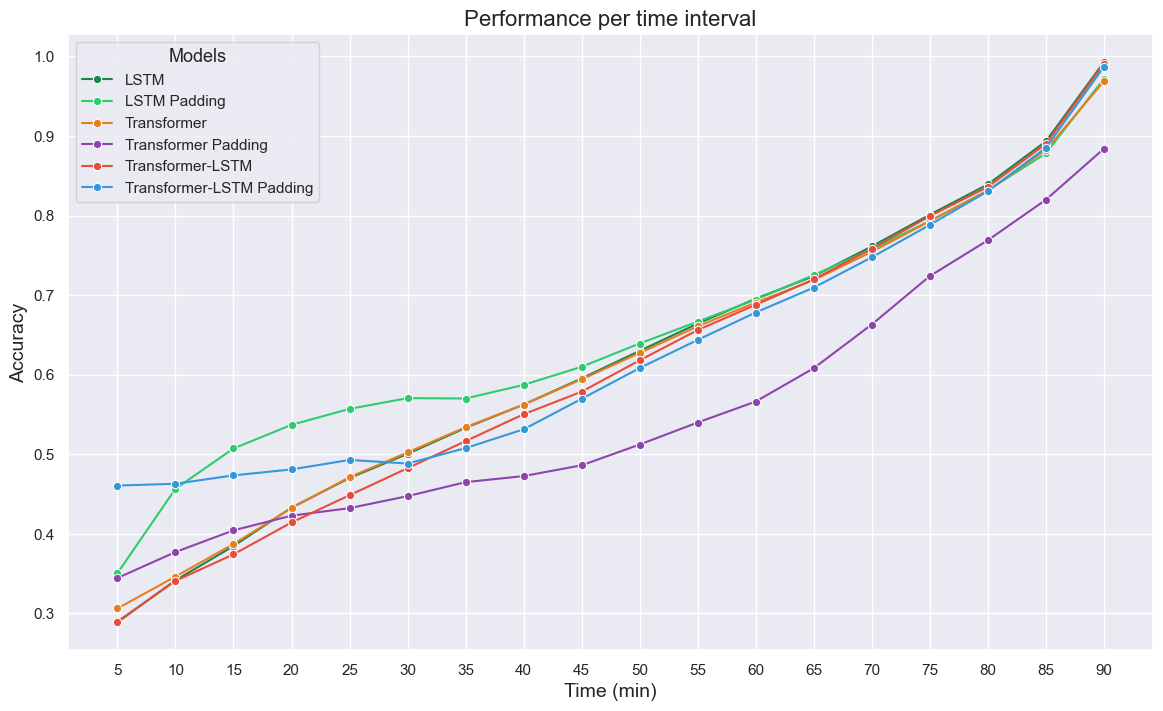

In [15]:
data_lists = general_accuracies

models = ['Transformer', 'Transformer Padding', 'Transformer-LSTM', 'Transformer-LSTM Padding', 'LSTM', 'LSTM Padding']

custom_palette = [ '#1e8449', '#2ecc71', '#e67e22','#8e44ad', '#e74c3c','#3498db']
palette = sns.color_palette(custom_palette)

hue_order = ['LSTM', 'LSTM Padding', 'Transformer', 'Transformer Padding', 'Transformer-LSTM', 'Transformer-LSTM Padding']

data = {'Time': np.arange(5, 90 + 1, 5)} 
for i, model in enumerate(models):
    data[model] = data_lists[i]

df = pd.DataFrame(data)
df = df.melt(id_vars='Time', var_name='Model', value_name='Accuracy')

plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
plot = sns.lineplot(data=df, x='Time', y='Accuracy', hue='Model', marker='o', hue_order=hue_order, palette=palette)

plot.set_title('Performance per time interval', fontsize=16)
plot.set_xlabel('Time (min)', fontsize=14)
plot.set_ylabel('Accuracy', fontsize=14)
plot.legend(title='Models', title_fontsize='13', fontsize='11')

plt.xticks(np.arange(5, 91, 5))
plt.savefig('desempeno_modelos.png', dpi=300, bbox_inches='tight')
plt.show()


In [20]:
np.mean(general_accuracies[0])

0.6146372571085603

In [25]:
# ['Transformer', 'Transformer Padding', 'Transformer-LSTM', 'Transformer-LSTM Padding', 'LSTM', 'LSTM Padding']
l = 0
for accs in general_accuracies:
    l+= 1
    print(f"Modelo:{l}")
    print(np.mean(accs))

Modelo:1
0.6146372571085603
Modelo:2
0.5521544501963138
Modelo:3
0.6084477455172932
Modelo:4
0.6303298572035912
Modelo:5
0.6172506097290251
Modelo:6
0.6502238197459115
